In [59]:
from pyproj import Proj
import numpy as np
from netCDF4 import Dataset
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour, RealWindHybrid, FastWindGrid
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(140, -39)
xmax, ymax = proj(157, -34)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 0, 1440
t_start_sec, t_end_sec = 0, 5 *24 *60 *60 #5 Days
sensors = RemoteSensingModel(num_particles=3, t_start=t_start_sec, t_end=t_end_sec)

# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start_sec, t_end_sec, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [40, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel = FastWindGrid(start_date="2019-12-25", num_days=5)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
# Load the NetCDF file
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191230.nc4"
dataset = Dataset(file_path, 'r')

from pyproj import Proj, Transformer

# Your UTM projection (Zone 56S)
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_wgs84)

# Convert all (x, y) to (lon, lat)
sensor_latlons = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    lon, lat = transformer.transform(x, y)
    sensor_latlons.append((lat, lon))

aod_times = dataset.variables['time'][:]
t_index = np.argmin(np.abs(aod_times - t_start))

lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
aod_data = dataset.variables['AODANA'][t_index]  # shape (361, 576)

Y = []
for lat, lon in sensor_latlons:
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))
    value = aod_data[lat_idx, lon_idx]
    Y.append(value)

Y = np.array(Y)
Y = np.nan_to_num(Y, nan=0.0)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-6)

# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
# Step setup
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
base_time = datetime(2019, 12, 25, 0, 0, 0)  # Adjust to your dataset's base time

# # Loop through time steps
# for t_index in range(0, res[0], 5):
#     real_seconds = boundary[0][0] + t_index * dt_seconds
#     real_datetime = base_time + timedelta(seconds=int(real_seconds))
#     timestamp_label = real_datetime.strftime("%Y-%m-%d %H:%M:%S")

#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 2, 1)
#     plt.title(f"Mean Source @ {timestamp_label}")
#     plt.imshow(sourcemean[t_index], origin='lower')
#     plt.colorbar()

#     plt.subplot(1, 2, 2)
#     plt.title(f"Std Source @ {timestamp_label}")
#     plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()



c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: RuntimeWarning: invalid value encountered in cast
  times = ds.variables['time'][:]
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = ds.variables['time'][:]


✅ Loaded 40 timestamps with shape (40, 11, 28)
Initialising particles...
Diffusing particles...
[⏱️] Time to computeModelRegressors(): 0.52 seconds
Computing SS...
Inverting SS...


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_15448\1580130165.py:95: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_15448\1580130165.py:95: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]


Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.83 seconds
Initialising particles...
Particle shape:
(5, 36000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 40, 30, 30)
Computing Source from Phi...
[⏱️] Time to computeConcentration(): 17.34 seconds
[✅] Total source inference pipeline took 18.70 seconds


In [31]:
import pandas as pd

csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2020_All_sites_air_quality.csv"

df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])


In [50]:
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)
filtered_df = df[(df['sample_datetime'] >= '2020-01-25') & 
                 (df['sample_datetime'] < '2020-01-31')]

pm25_df = filtered_df[filtered_df['param_short_name'] == 'PM2.5']

from geopy.distance import geodesic

fire_coord = (-37.4616, 149.697)
pm25_df = pm25_df.dropna(subset=['latitude', 'longitude'])

# Create a copy to avoid SettingWithCopyWarning
pm25_df = pm25_df.copy()


print(pm25_df)

        sample_point_id    sp_name   latitude   longitude     sample_datetime  \
150826            10219  Churchill -38.304314  146.414932 2020-01-25 00:00:00   
150828            10219  Churchill -38.304314  146.414932 2020-01-25 01:00:00   
150830            10219  Churchill -38.304314  146.414932 2020-01-25 02:00:00   
150832            10219  Churchill -38.304314  146.414932 2020-01-25 03:00:00   
150834            10219  Churchill -38.304314  146.414932 2020-01-25 04:00:00   
...                 ...        ...        ...         ...                 ...   
718852            10011  Traralgon -38.194283  146.531464 2020-01-30 19:00:00   
718864            10011  Traralgon -38.194283  146.531464 2020-01-30 20:00:00   
718876            10011  Traralgon -38.194283  146.531464 2020-01-30 21:00:00   
718888            10011  Traralgon -38.194283  146.531464 2020-01-30 22:00:00   
718900            10011  Traralgon -38.194283  146.531464 2020-01-30 23:00:00   

                         pa

['Churchill' 'Footscray' 'Melbourne CBD' 'Moe' 'Morwell East'
 'Morwell South' 'Newborough' 'Traralgon']


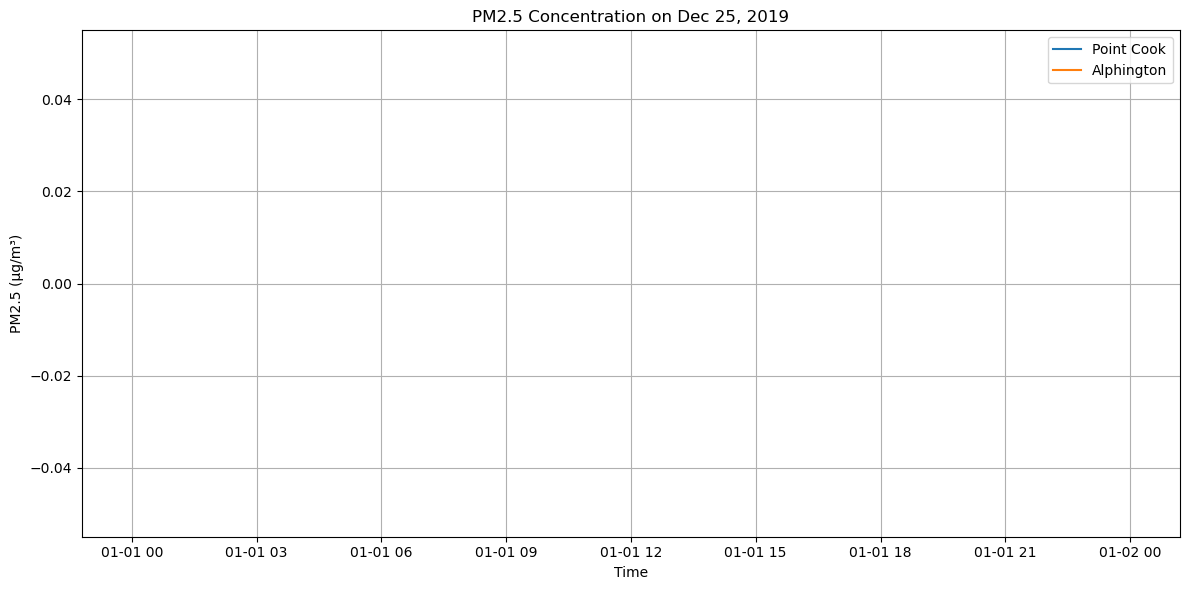

In [51]:
import matplotlib.pyplot as plt

# Stations you're interested in (add more if needed)
stations_of_interest = ['Point Cook', 'Alphington']
pm25_subset = pm25_df[pm25_df['sp_name'].isin(stations_of_interest)]
print(pm25_df['sp_name'].unique())

plt.figure(figsize=(12, 6))

for station in stations_of_interest:
    station_data = pm25_subset[pm25_subset['sp_name'] == station]
    plt.plot(
        station_data['sample_datetime'], 
        station_data['value'], 
        label=station
    )

plt.title("PM2.5 Concentration on Dec 25, 2019")
plt.xlabel("Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
print(station_data['sample_datetime'])
print(station_data['value'])

Series([], Name: sample_datetime, dtype: datetime64[ns])
Series([], Name: value, dtype: float64)


In [53]:
import pandas as pd
from geopy.distance import geodesic

# Load your CSV
csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2020_All_sites_air_quality.csv"
df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])

# Convert datetime (using dayfirst format)
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)

# 🔁 Select your date of interest — here March 3rd, 2020
filtered_df = df[(df['sample_datetime'].dt.date == pd.to_datetime('2020-01-25').date())]

# Filter PM2.5 records
pm25_df = filtered_df[filtered_df['param_short_name'] == 'PM2.5']

# Drop rows missing location info
pm25_df = pm25_df.dropna(subset=['latitude', 'longitude'])

# Add distance to fire origin (if you want to sort by it)
fire_coord = (-37.4616, 149.697)
pm25_df['distance_km'] = pm25_df.apply(
    lambda row: geodesic(fire_coord, (row['latitude'], row['longitude'])).km,
    axis=1
)

# ✅ Group by station name and show average PM2.5 value + distance
summary = pm25_df.groupby(['sp_name', 'latitude', 'longitude'])['value'].mean().reset_index()
summary['distance_km'] = summary.apply(
    lambda row: geodesic(fire_coord, (row['latitude'], row['longitude'])).km, axis=1
)

# Sort by distance if you want to see the closest ones first
summary = summary.sort_values(by='distance_km')

# Print!
print(summary)


         sp_name   latitude   longitude     value  distance_km
6      Traralgon -38.194283  146.531464  6.041667   290.290255
4   Morwell East -38.229393  146.424454  2.800000   300.360196
0      Churchill -38.304314  146.414932  5.920833   303.481514
5  Morwell South -38.239292  146.387299  9.000000   303.788475
3            Moe -38.186466  146.258331  5.104167   313.233130
2  Melbourne CBD -37.807396  144.970001  6.708333   418.951861
1      Footscray -37.804878  144.872803  7.279167   427.475268


In [56]:
stations_of_interest = ['Traralgon', 'Morwell East', 'Churchill']

# Filter the full PM2.5 dataframe to only these stations
pm25_selected = pm25_df[pm25_df['sp_name'].isin(stations_of_interest)]

# Just to be sure, let's sort by time
pm25_selected = pm25_selected.sort_values(by='sample_datetime')

# Print relevant columns
print(pm25_selected[['sample_datetime', 'sp_name', 'value']])

daily_pm25 = pm25_df[
    (pm25_df['sample_datetime'].dt.date == current_date) & 
    (pm25_df['sp_name'].isin(stations_of_interest))
]


           sample_datetime       sp_name  value
150826 2020-01-25 00:00:00     Churchill    6.3
717221 2020-01-25 00:00:00     Traralgon    8.9
554722 2020-01-25 00:00:00  Morwell East    1.5
150828 2020-01-25 01:00:00     Churchill    5.9
717232 2020-01-25 01:00:00     Traralgon    8.5
...                    ...           ...    ...
150870 2020-01-25 22:00:00     Churchill    5.5
554850 2020-01-25 22:00:00  Morwell East   -2.6
554856 2020-01-25 23:00:00  Morwell East   -0.1
150872 2020-01-25 23:00:00     Churchill    5.4
717491 2020-01-25 23:00:00     Traralgon    3.1

[72 rows x 3 columns]


NameError: name 'current_date' is not defined

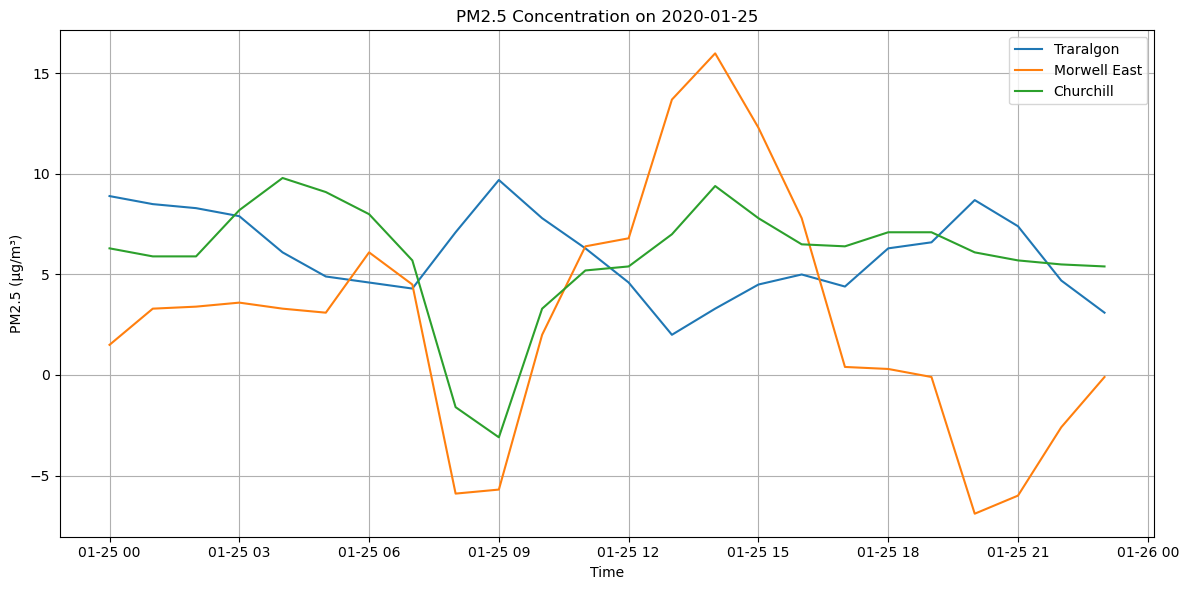

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for station in stations_of_interest:
    station_data = pm25_selected[pm25_selected['sp_name'] == station]
    plt.plot(station_data['sample_datetime'], station_data['value'], label=station)

plt.title("PM2.5 Concentration on 2020-01-25")
plt.xlabel("Time")
plt.ylabel("PM2.5 (μg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd

# === Fire shapefile ===
fire_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Order_CD850U\mga94_54\esrishape\cma100\East Gippsland-0\FIRE\FIRE_HISTORY_ORIGIN.shp"
gdf = gpd.read_file(fire_path)
gdf = gdf.to_crs(epsg=4326)  # convert to lat/lon

# === Filter fires between Dec 2019 and Jan 2020 ===
gdf['FIRE_START'] = pd.to_datetime(gdf['FIRE_START'], errors='coerce')
filtered_fires = gdf[
    (gdf['FIRE_START'] >= '2019-12-25') & 
    (gdf['FIRE_START'] <= '2020-01-05')
]

# === AOD data config ===
start_date = datetime(2020, 01, 25)
num_days = 5
folder_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD"
file_template = "MERRA2_400.inst3_2d_gas_Nx.{}.nc4"

# === Wind Visualization Overlay ===
wind_folder_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind"
wind_template = "MERRA2_400.tavg3_3d_asm_Nv.{}.nc4"
layer = 60
step = 5

#=== Sourcemean ===
from pyproj import Transformer

# Convert UTM boundary to lat/lon using pyproj
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj_utm, "epsg:4326", always_xy=True)

(tmin, xmin, ymin), (tmax, xmax, ymax) = boundary
lon_min, lat_min = transformer.transform(xmin, ymin)
lon_max, lat_max = transformer.transform(xmax, ymax)

lat_bins = np.linspace(lat_min, lat_max, sourcemean.shape[1])
lon_bins = np.linspace(lon_min, lon_max, sourcemean.shape[2])
lon_grid_source, lat_grid_source = np.meshgrid(lon_bins, lat_bins)

# === Loop through AOD files ===
for day_offset in range(num_days):
    date = start_date + timedelta(days=day_offset)
    date_str = date.strftime('%Y%m%d')

    # Load AOD
    aod_path = os.path.join(folder_path, file_template.format(date_str))
    if not os.path.exists(aod_path): continue
    ds_aod = Dataset(aod_path)
    aod_data = ds_aod.variables["AODANA"][:]  # shape (8, 361, 576)
    aod_times = ds_aod.variables["time"][:]   # in minutes
    aod_lats = ds_aod.variables["lat"][:]
    aod_lons = ds_aod.variables["lon"][:]
    aod_lon_grid, aod_lat_grid = np.meshgrid(aod_lons, aod_lats)

    # Load wind
    wind_path = os.path.join(wind_folder_path, wind_template.format(date_str))
    if not os.path.exists(wind_path): continue
    ds_wind = Dataset(wind_path)
    wind_lats = ds_wind.variables["lat"][:]
    wind_lons = ds_wind.variables["lon"][:]
    wind_times = ds_wind.variables["time"][:]  # in hours
    U = ds_wind.variables["U"][:, layer, :, :]
    V = ds_wind.variables["V"][:, layer, :, :]
    wind_lon_grid, wind_lat_grid = np.meshgrid(wind_lons, wind_lats)
    
    # Prevent duplicate legends
    handles, labels = ax2.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax2.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

    for t_index in range(aod_data.shape[0]):
        timestamp = date + timedelta(minutes=int(aod_times[t_index]))
        current_date = timestamp.date()

        # Find nearest wind index by time (convert AOD minutes to hours)
        wind_time_diff = np.abs(wind_times * 60 - aod_times[t_index])
        wind_index = np.argmin(wind_time_diff)

        # Prepare slices
        aod_slice = np.nan_to_num(aod_data[t_index], nan=0.0)
        norm_aod = (aod_slice - np.min(aod_slice)) / (np.max(aod_slice) + 1e-6)
        u_slice = U[wind_index][::step, ::step]
        v_slice = V[wind_index][::step, ::step]
        lon_sub = wind_lon_grid[::step, ::step]
        lat_sub = wind_lat_grid[::step, ::step]

        # Fires on this day
        daily_fires = filtered_fires[filtered_fires['FIRE_START'].dt.date == current_date]

        # === Plot ===
        # === Plot side-by-side ===
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        
       # === LEFT: PM2.5 Ground Observations ===
        ax1 = axes[0]
        ax1.set_extent([140.5, 157, -39, -34])
        ax1.add_feature(cfeature.COASTLINE)
        ax1.add_feature(cfeature.BORDERS)
        ax1.add_feature(cfeature.LAND, facecolor='lightgray')
        ax1.set_title(f"PM2.5 Ground Observations @ {timestamp.strftime('%Y-%m-%d %H:%M')}")
        
        # Filter PM2.5 for this datetime
        pm25_time_filtered = pm25_df[pm25_df['sample_datetime'].dt.date == current_date]
        
        for _, row in pm25_time_filtered.iterrows():
            ax1.scatter(row['longitude'], row['latitude'],
                        s=row['value'] * 3,
                        color='blue', alpha=0.7,
                        transform=ccrs.PlateCarree(),
                        label=f"{row['sp_name']} ({row['value']} µg/m³)")
        
        # Remove duplicate legend entries
        handles1, labels1 = ax1.get_legend_handles_labels()
        unique_labels1 = dict(zip(labels1, handles1))
        ax1.legend(unique_labels1.values(), unique_labels1.keys(), loc='upper right')


        
        # === RIGHT: AOD + Wind + Fire ===
        ax2 = axes[1]
        ax2.set_extent([140.5, 157, -39, -34])
        ax2.add_feature(cfeature.COASTLINE)
        ax2.add_feature(cfeature.BORDERS)
        ax2.add_feature(cfeature.LAND, facecolor='lightgray')
        
        cf2 = ax2.contourf(aod_lon_grid, aod_lat_grid, norm_aod, levels=30, cmap='plasma', transform=ccrs.PlateCarree())
        fig.colorbar(cf2, ax=ax2, orientation='vertical', label='Normalized AOD')
        ax2.quiver(lon_sub, lat_sub, u_slice, v_slice, transform=ccrs.PlateCarree(), color='white', scale=1000)
        
        if not daily_fires.empty:
            daily_fires.plot(ax=ax2, color='red', markersize=20, label='Fire Start')
            ax2.legend(loc='lower right')
        
        ax2.set_title(f"AOD + Wind + Fire @ {timestamp.strftime('%Y-%m-%d %H:%M')}")
        # PM2.5 overlay — filter only those with matching datetime
        pm25_time_filtered = pm25_df[pm25_df['sample_datetime'].dt.date == current_date]
        
        # Plot PM2.5 readings
        for _, row in pm25_time_filtered.iterrows():
            ax2.scatter(row['longitude'], row['latitude'],
                        s=row['value'] * 3,
                        color='blue', alpha=0.7,
                        transform=ccrs.PlateCarree(),
                        label=f"{row['sp_name']} ({row['value']} µg/m³)")
        
        # Prevent duplicate legends
        handles, labels = ax2.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        ax2.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
        plt.tight_layout()
        plt.show()

    ds_aod.close()
    ds_wind.close()
        



SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3490683101.py, line 24)

In [64]:
print(pm25_time_filtered[['sp_name', 'latitude', 'longitude', 'value']])


Empty DataFrame
Columns: [sp_name, latitude, longitude, value]
Index: []
